# 03 - Flow and Scalar Statistics

Leverage the analysis utilities to quantify structure functions and increment statistics for both the velocity and scalar fields.

**In this notebook**
- Run a short simulation to generate coupled velocity/scalar snapshots
- Compute structure functions in physical space
- Analyse pair-increment probability density functions

In [1]:
import sys, pathlib
project_root = pathlib.Path().resolve()
if not (project_root / 'scalar_advection').exists():
    for parent in project_root.parents:
        if (parent / 'scalar_advection').exists():
            project_root = parent
            break
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scalar_advection import (
    ScalarAdvectionAPI,
    VelocityConfig,
    ScalarConfig,
    structure_functions,
    plot_structure_functions,
    pair_increment_pdf,
    plot_pair_increment_pdf,
    structure_functions_from_pair_pdf,
    generate_divfree_field,
)

In [4]:
# Optimise FFT threading for this session (adjust thread count as needed).
ScalarAdvectionAPI.set_fft_threads(8)

## Fourier-based velocity (mean-gradient forcing)

Simulate with a spectral velocity field, smooth scalar initial state, and mean-gradient forcing.

In [5]:
N = 512
api = ScalarAdvectionAPI(N=N, L=1.0, warm_cache=True)

velocity_config_fourier = VelocityConfig(beta=5/3, urms=1.0, seed=21)
ux_fourier, uy_fourier = api.generate_velocity(velocity_config_fourier)

theta0_uniform = np.zeros((N, N), dtype=api.grid.dtype)
scalar_config_fourier = ScalarConfig(
    peclet=2000,
    t_end=1.0,
    mean_grad=(1.0, 0.0),
    save_every=50,
)
theta_fourier, diagnostics_fourier = api.evolve_scalar(
    theta0_uniform, ux_fourier, uy_fourier, scalar_config_fourier, verbose=False
)
diagnostics_fourier.n_steps

5407

## Wavelet-based velocity (mean-gradient forcing)

To keep runtime manageable we step the wavelet-driven case with float32 state and a cheaper RK4 integrator.

In [6]:
api_wavelet = ScalarAdvectionAPI(N=N, L=1.0, dtype=np.float32, warm_cache=True)

ux_wavelet, uy_wavelet, speed_wavelet = generate_divfree_field(
    N=N,
    lam_min=6,
    lam_max=N // 2,
    slope=-5/3,
    wavelet='mexh',
    sparsity=0.0,
    seed=42,
)
ux_wavelet = ux_wavelet.astype(api_wavelet.grid.dtype, copy=False)
uy_wavelet = uy_wavelet.astype(api_wavelet.grid.dtype, copy=False)

theta0_wavelet = np.zeros((N, N), dtype=api_wavelet.grid.dtype)
scalar_config_wavelet = ScalarConfig(
    peclet=2000,
    t_end=0.3,
    mean_grad=(1.0, 0.0),
    save_every=25,
    integrator='rk4',
)
theta_wavelet, diagnostics_wavelet = api_wavelet.evolve_scalar(
    theta0_wavelet, ux_wavelet, uy_wavelet, scalar_config_wavelet, verbose=False
)
diagnostics_wavelet.n_steps

13335

## Structure functions

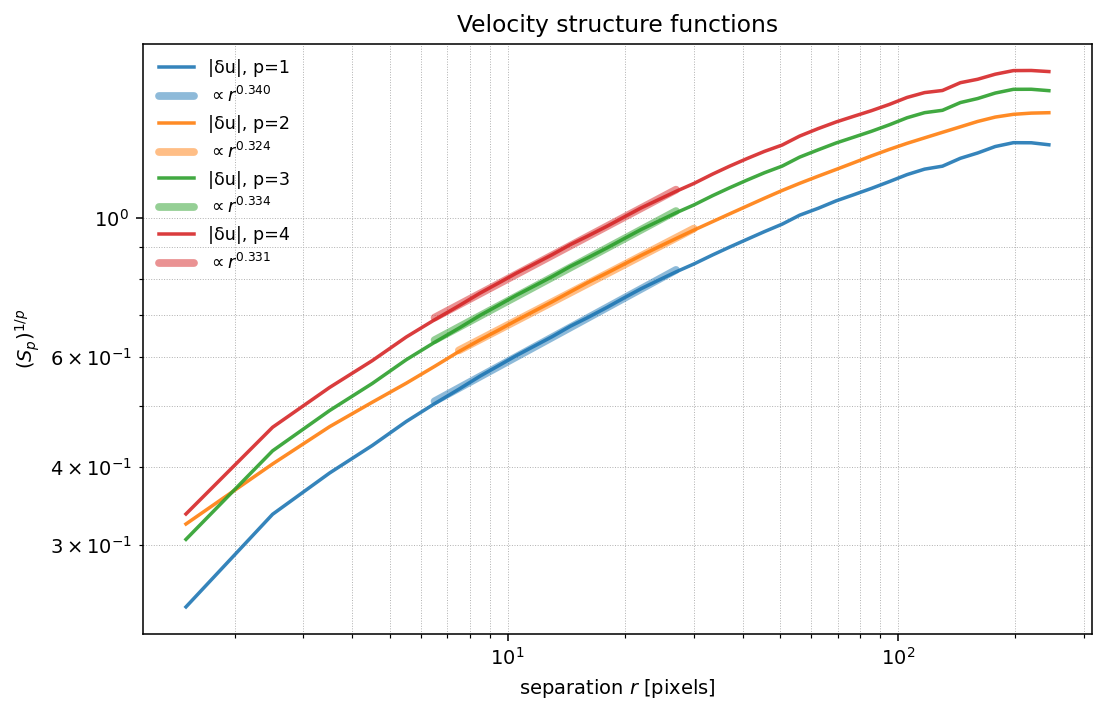

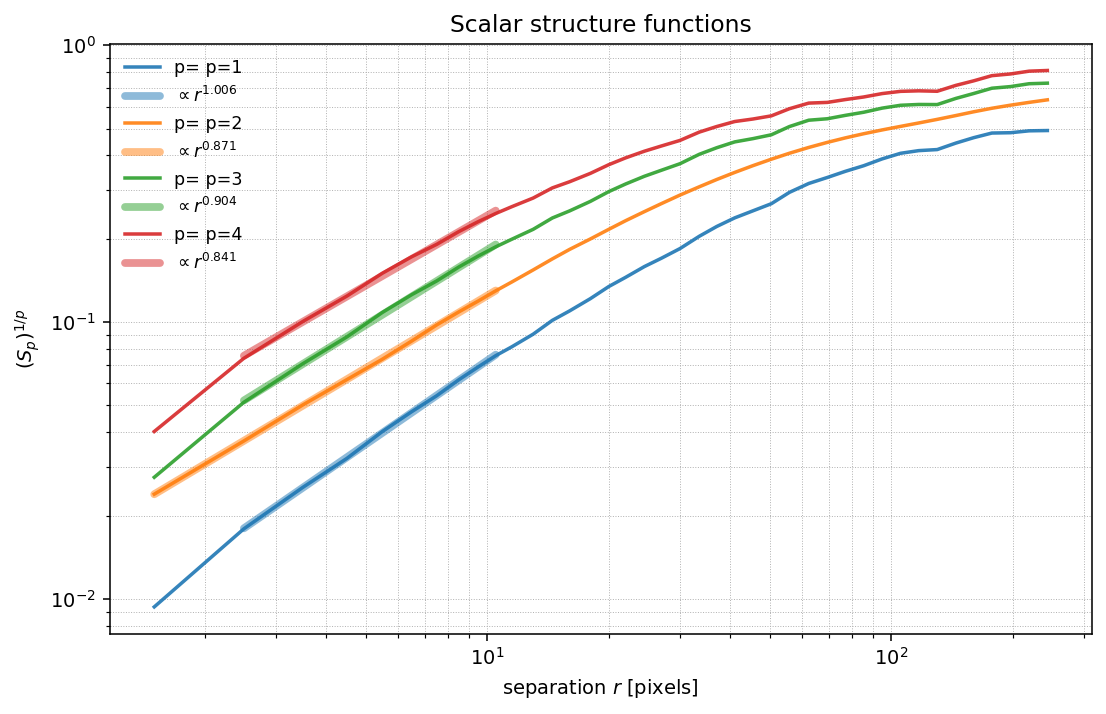

In [7]:
orders = (1, 2, 3, 4)
sf_velocity = structure_functions((ux_fourier, uy_fourier), orders=orders, n_ell_bins=40, n_disp_total=4096, seed=0)
sf_scalar = structure_functions(theta_fourier, orders=orders, n_ell_bins=40, n_disp_total=4096, seed=0)
plot_structure_functions(sf_velocity, title='Velocity structure functions', plot_long_and_tran=False)
plot_structure_functions(sf_scalar, title='Scalar structure functions', plot_long_and_tran=False)

## Pair-increment PDF of velocity increments

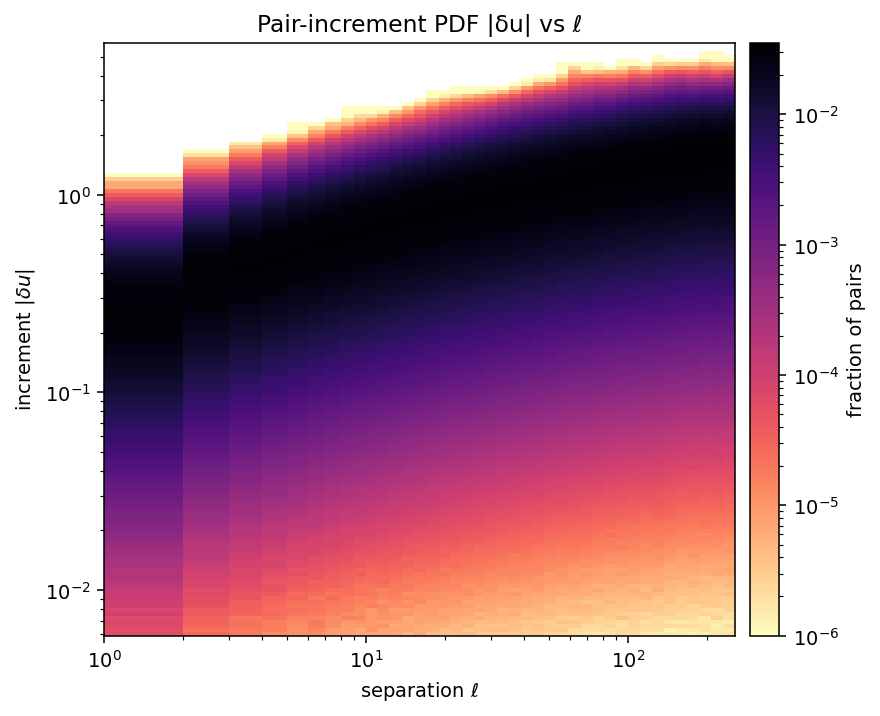

In [8]:
pdf_mag_fourier = pair_increment_pdf((ux_fourier, uy_fourier), kind='mag', n_ell_bins=40, n_disp_total=4096, n_du_bins=150, seed=1)
plot_pair_increment_pdf(
    pdf_mag_fourier,
    title='Pair-increment PDF |δu| vs ℓ',
    cmap='magma_r',
    norm_kwargs={'vmin': 1e-6}
)

### Recover structure functions from the PDF

/Users/dbf75/Work/Research/fractal_projections/scalar_advection/development/scalar_advection/structure.py:719: RuntimeWarning: divide by zero encountered in matmul
  S[j, :] = pdf @ weights
/Users/dbf75/Work/Research/fractal_projections/scalar_advection/development/scalar_advection/structure.py:719: RuntimeWarning: overflow encountered in matmul
  S[j, :] = pdf @ weights
/Users/dbf75/Work/Research/fractal_projections/scalar_advection/development/scalar_advection/structure.py:719: RuntimeWarning: invalid value encountered in matmul
  S[j, :] = pdf @ weights


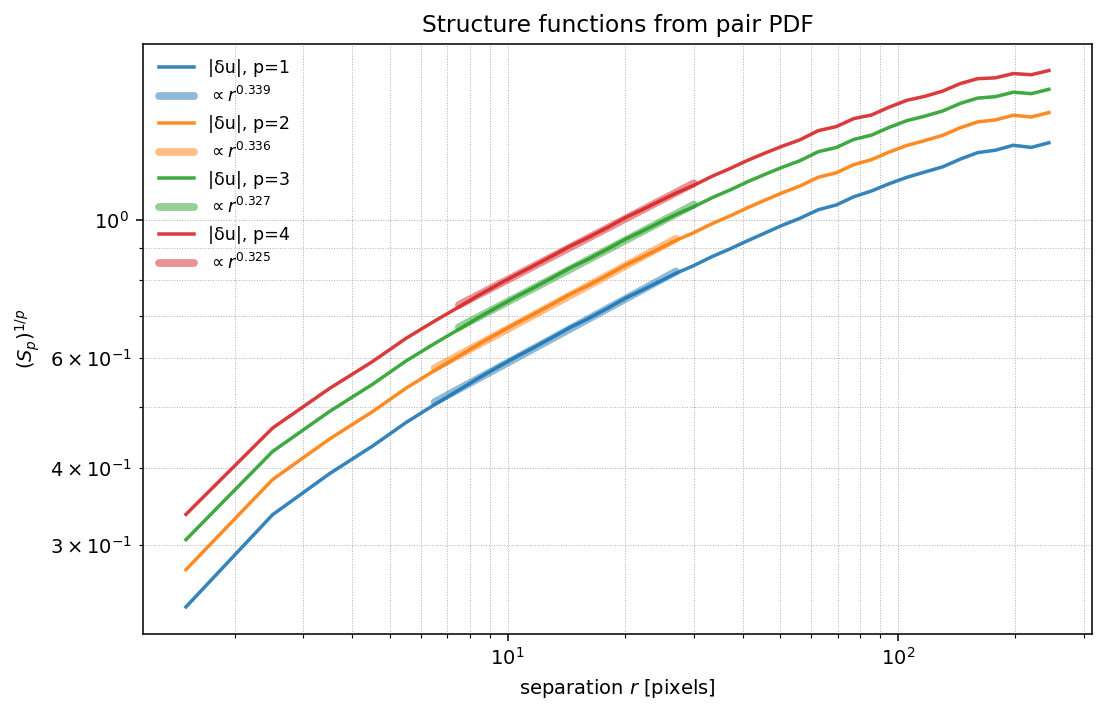

In [9]:
sf_from_pdf = structure_functions_from_pair_pdf(pdf_mag_fourier, orders=orders)
plot_structure_functions(sf_from_pdf, title='Structure functions from pair PDF', plot_long_and_tran=False)

These tools give you ready-to-plot diagnostics, but the returned dictionaries also contain raw arrays so you can integrate them into bespoke analysis pipelines.